In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import os
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from math import sqrt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')



/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
os.chdir('Data2/')

# Import and Prepare Data

In [3]:
df = pd.read_pickle('All_Data')

In [4]:
df.reset_index(drop=True,inplace=True)

In [5]:
df['Max_Beer_Score'] = df.Max_Beer_Score.replace(0,np.nan)
df['Mean_Beer_Score'] = df.Mean_Beer_Score.replace(0,np.nan)
df['Num_Beers'] = df.Num_Beers.replace(0,np.nan)
df['Total_Beer_Reviews'] = df.Total_Beer_Reviews.replace(0,np.nan)
df['Total_Beer_Ratings'] = df.Total_Beer_Ratings.replace(0,np.nan)
df['Num_Brewery_Reviews'] = df.Total_Beer_Reviews.replace(0,np.nan)
df['Num_Brewery_Ratings'] = df.Total_Beer_Ratings.replace(0,np.nan)

In [6]:
df.dropna(inplace=True)

In [7]:
df = df[df.Total_Beer_Reviews < 300]

In [8]:
lamb1=stats.boxcox_normmax(df.Total_Beer_Ratings, brack=(-1.9, 1.9)) 
lamb2=stats.boxcox_normmax(df.Total_Beer_Reviews, brack=(-1.9, 1.9))
lamb3=stats.boxcox_normmax(df.Num_Brewery_Ratings, brack=(-1.9, 1.9))
lamb4=stats.boxcox_normmax(df.Num_Brewery_Reviews, brack=(-1.9, 1.9))

In [9]:
df['Lam_Total_Beer_Ratings'] = (np.power(df.Total_Beer_Ratings,lamb1)-1)/lamb1
df['Lam_Total_Beer_Reviews'] = (np.power(df.Total_Beer_Reviews,lamb2)-1)/lamb2
df['Lam_Num_Brewery_Ratings'] = (np.power(df.Num_Brewery_Ratings,lamb3)-1)/lamb3
df['Lam_Num_Brewery_Reviews'] = (np.power(df.Num_Brewery_Reviews,lamb4)-1)/lamb4

df['Wild_Sour'] = df.Mean_Wild_Sour * df.Max_Wild_Sour
df['Lam_Brew_Rats_Revs'] = df['Lam_Num_Brewery_Ratings'] * df['Lam_Num_Brewery_Reviews']
df['Lam_Beer_Rats_Revs'] = df['Lam_Total_Beer_Ratings'] * df['Lam_Total_Beer_Reviews']
df['Max_Times_Mean_Beer_Score'] = df['Max_Beer_Score'] * df['Max_Mean_Beer_Score'] * df['Mean_Beer_Score']

In [10]:
df = df[['Brewery_Score','Eatery', 'Lam_Total_Beer_Ratings', 'Lam_Total_Beer_Reviews', 
        'Lam_Num_Brewery_Ratings', 'Lam_Num_Brewery_Ratings', 
        'Num_Beers', 'Max_Beer_Score', 'Max_Mean_Beer_Score', 
        'Mean_Beer_Score','Lam_Brew_Rats_Revs','Lam_Beer_Rats_Revs',
        'Max_Times_Mean_Beer_Score','Count_IPA_Pale_Ale','Wild_Sour']]

In [11]:
X, y = df.drop('Brewery_Score',axis=1), df['Brewery_Score']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

# Test and Compare Models

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state = 101)
lm_r2, rm_r2, sm_r2, OLS = [], [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind] 
    
    #LASSO Model
    lasso_model = Lasso(alpha = .00044, max_iter = 60)
    lasso_model.fit(X_train, y_train)
    lm_r2.append(lasso_model.score(X_val,y_val))
    
    #Ridge Model
    lr_model_ridge = Ridge(alpha = 38, max_iter = 10)
    lr_model_ridge.fit(X_train, y_train)
    rm_r2.append(lr_model_ridge.score(X_val,y_val))
    
    #Standard Model
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    sm_r2.append(lr.score(X_val,y_val))

print('LASSO Model: ', lm_r2, '\n')
print('Ridge Model: ', rm_r2, '\n')
print('Standard Model: ', sm_r2, '\n')

print('LASSO Model Adjusted r^2: ' + str(1 - (1-np.mean(lm_r2))*
      (len(y_test)-1)/(len(y_val)-X_test.shape[1]-1)))
print('Ridge Model Adjusted r^2: ' + str(1 - (1-np.mean(rm_r2))*
      (len(y_test)-1)/(len(y_val)-X_test.shape[1]-1)))
print('Standard Model Adjusted r^2: ' + str(1 - (1-np.mean(sm_r2))*
      (len(y_test)-1)/(len(y_val)-X_test.shape[1]-1)))

print()

print(f'LASSO Model cv r^2: {np.mean(lm_r2):.3f} +- {np.std(lm_r2):.3f}')
print(f'Ridge Model cv r^2: {np.mean(rm_r2):.3f} +- {np.std(rm_r2):.3f}')
print(f'Standard Model cv r^2: {np.mean(sm_r2):.3f} +- {np.std(sm_r2):.3f}')

print()

print(sqrt(mean_squared_error(y_test, predictions)))

LASSO Model:  [0.20614589422829166, 0.2577607889276675, 0.22667738855164155, 0.20021331478971957, 0.1570958440104615] 

Ridge Model:  [0.20550798833942507, 0.257307758336341, 0.22951669724933976, 0.19852648289848784, 0.15625708418169915] 

Standard Model:  [0.20499114777933425, 0.25934854171325916, 0.22694795796912848, 0.19899131164183226, 0.1551241909202716] 

LASSO Model Adjusted r^2: 0.19579795001864453
Ridge Model Adjusted r^2: 0.19563979601278314
Standard Model Adjusted r^2: 0.19529125120036506

LASSO Model cv r^2: 0.210 +- 0.033
Ridge Model cv r^2: 0.209 +- 0.034
Standard Model cv r^2: 0.209 +- 0.034


In [36]:

#LASSO Model
lasso_model = Lasso(alpha = .00044, max_iter = 60)
lasso_model.fit(X, y)
lm_predictions = lasso_model.predict(X_test)

#Ridge Model
lr_model_ridge = Ridge(alpha = 38, max_iter = 10)
lr_model_ridge.fit(X, y)
rm_predictions = lr_model_ridge.predict(X_test)

#Standard Model
lr = LinearRegression()
lr.fit(X, y)
sm_predictions = lr.predict(X_test)

print(sqrt(mean_squared_error(y_test, lm_predictions)))
print(sqrt(mean_squared_error(y_test, rm_predictions)))
print(sqrt(mean_squared_error(y_test, sm_predictions)))

0.29223555876111673
0.29237698967231046
0.2922052092174904


In [16]:
predictions = lasso_model.predict(X_test)

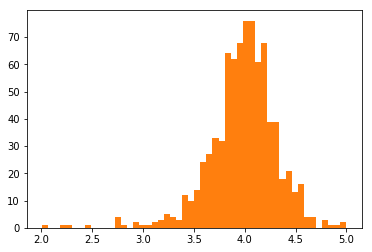

In [19]:
plt.hist(predictions,bins=50);
plt.hist(y_test,bins=50);

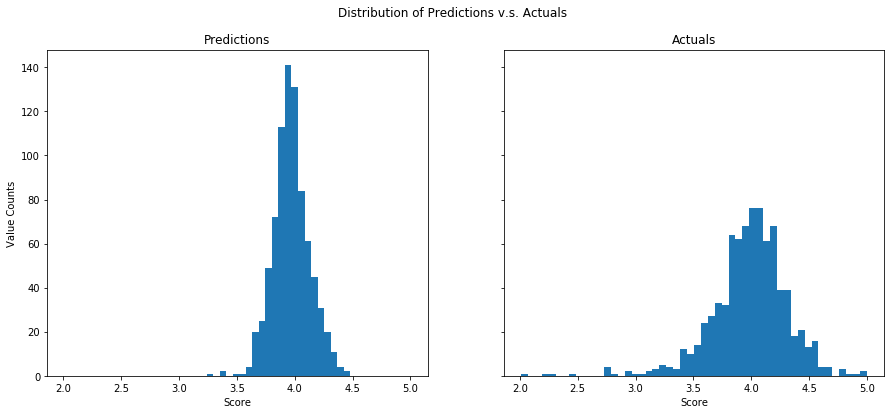

In [47]:
#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True)
f.suptitle('Distribution of Predictions v.s. Actuals')
f.set_figheight(6)
f.set_figwidth(15)

ax1.set_title('Predictions')
ax1.hist(predictions,bins=22)
ax2.set_title('Actuals')
ax2.hist(y_test,bins=50)

ax1.set_xlabel('Score')
ax2.set_xlabel('Score')
ax1.set_ylabel('Value Counts');

f.savefig('Predictions_v_Actuals')